In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pickle

## Load trees from results directory

In [2]:
results = glob.glob("../nextflow/results/*")[-1]
results

'../nextflow/results/2022-04-01'

In [223]:
def gc_key(file):
    PR_str = file.split("/")[-2].split("-")
    return int(PR_str[1]), int(PR_str[3])

files = sorted(glob.glob(f"{results}/gctrees/PR*/gctree.p"), key=gc_key)
trees = {"_".join(f"{x}{y}" for x, y in zip(("mouse", "GC"), gc_key(file))): pickle.load(open(file, "rb"))
         for file in files}

print(f"loaded {len(trees)} GC trees")

loaded 77 GC trees


## Data frame with a row for each edge on each tree, excluding 10-week mice
Exclude root and leaves

In [226]:
rows = []
for gc, tree in trees.items():
    for node in tree.tree.traverse():
        if (not node.is_root()) and (node.abundance > 1 or not node.is_leaf()):
            delta_delta_bind = node.delta_bind - node.up.delta_bind
            delta_delta_expr = node.delta_expr - node.up.delta_expr
            polytomy_degree = len(node.children) + node.abundance
            rows.append([gc, node.name, node.get_distance(tree.tree), node.abundance, polytomy_degree, node.LBI, node.LBR, node.delta_bind, delta_delta_bind, node.delta_expr, delta_delta_expr])
df = pd.DataFrame(rows, columns=["GC", "name", "divergence", "abundance", "polytomy degree", "LBI", "LBR", "affinity", r"parent edge $\Delta$ affinity", "expression", r"parent edge $\Delta$ expression"])

# no 10-week
df = df.loc[~df.GC.str.startswith("mouse7") & ~df.GC.str.startswith("mouse8")]

df

,GC,name,divergence,abundance,polytomy degree,LBI,LBR,affinity,parent edge $\Delta$ affinity,expression,parent edge $\Delta$ expression
0,mouse1_GC1,seq56,1.0,1,2,5.252151,0.223615,-0.80796,-0.80796,-0.15104,-0.15104
1,mouse1_GC1,25,4.0,0,2,3.107390,1.669774,-7.71074,-7.71074,-0.77924,-0.77924
2,mouse1_GC1,2,1.0,0,10,18.789397,3.377441,0.33100,0.33100,-0.00561,-0.00561
3,mouse1_GC1,seq14,3.0,1,2,4.452909,0.306784,0.81725,0.48625,-0.01130,-0.00569
4,mouse1_GC1,36,5.0,0,2,3.257721,1.457129,1.17254,0.84154,-0.04044,-0.03483
...,...,...,...,...,...,...,...,...,...,...,...
1738,mouse6_GC77,seq51,4.0,2,2,3.424837,0.058842,0.96027,0.00000,-1.15282,0.00000
1739,mouse6_GC77,35,7.0,0,2,4.901709,0.606158,0.75399,-0.01297,-0.72151,-0.10773
1740,mouse6_GC77,seq3,12.0,2,2,1.203368,0.187875,-0.00518,-1.19916,-0.31626,-0.24044
1741,mouse6_GC77,seq37,8.0,3,4,2.629712,0.535954,1.08960,-0.10438,-0.12466,-0.04884


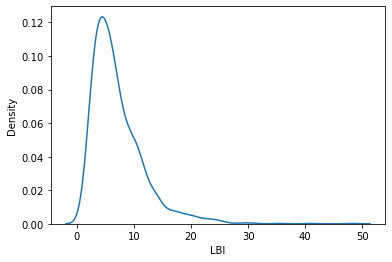

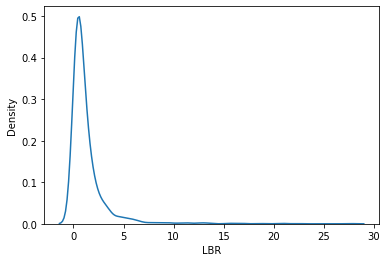

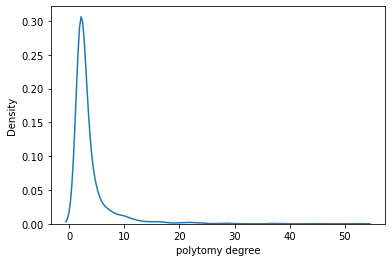

In [227]:
sns.kdeplot(data=df, x="LBI")
plt.show()

sns.kdeplot(data=df, x="LBR")
plt.show()

sns.kdeplot(data=df, x="polytomy degree")
plt.show()

In [228]:
thresh = 10
df["burst"] = df["polytomy degree"] >= thresh

df = df.sort_values("polytomy degree")

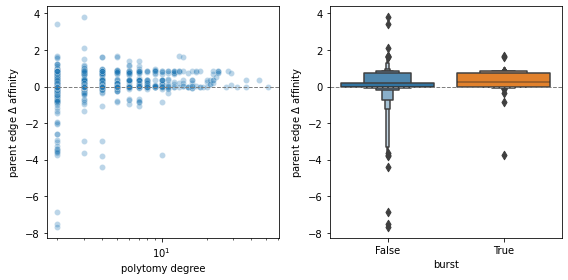

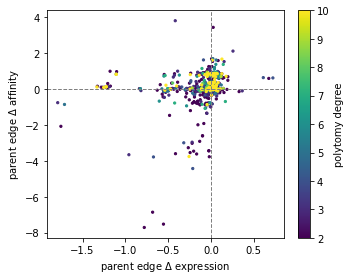

In [239]:
plt.figure(figsize=(8, 4))

plt.subplot(121)
g = sns.scatterplot(data=df, y=r"parent edge $\Delta$ affinity", x="polytomy degree", alpha=0.3)
plt.axhline(0, c="grey", ls="--", lw=1)
plt.xscale("log")

plt.subplot(122, sharey=g)
sns.boxenplot(data=df, y=r"parent edge $\Delta$ affinity", x="burst")
plt.axhline(0, c="grey", ls="--", lw=1)

plt.tight_layout()
plt.savefig("output/plots/affinity-fitness.polytomy_degree_Vs_bind.pdf")
plt.show()

plt.figure(figsize=(5, 4))
plt.scatter(x=df[r"parent edge $\Delta$ expression"], y=df[r"parent edge $\Delta$ affinity"],
            c=df["polytomy degree"],
            s=5,
            vmax=10,
           )
plt.axvline(0, c="grey", ls="--", lw=1)
plt.axhline(0, c="grey", ls="--", lw=1)
plt.ylabel(r"parent edge $\Delta$ affinity")
plt.xlabel(r"parent edge $\Delta$ expression")
plt.colorbar(label="polytomy degree")

plt.tight_layout()
plt.savefig("output/plots/affinity-fitness.scatter.pdf")
plt.show()

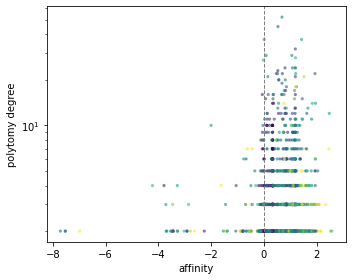

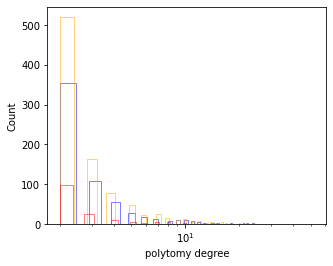

In [233]:
# df = df[df.divergence > 5]

plt.figure(figsize=(5, 4))
plt.scatter(x=df.affinity, y=df["polytomy degree"], c=df.divergence,
            alpha=0.5,
            s=5,
            vmax=10,
           )
plt.axvline(0, c="grey", ls="--", lw=1)
plt.xlabel(r"affinity")
plt.ylabel("polytomy degree")
plt.yscale("log")

plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 4))
sns.histplot(data=df[df.affinity > 1], x="polytomy degree", color="b", fill=False)
sns.histplot(data=df[(df.affinity < 1) & (df.affinity > 0)], x="polytomy degree", color="orange", fill=False)
sns.histplot(data=df[(df.affinity < 0)], x="polytomy degree", color="r", fill=False)
plt.xscale("log")
plt.show()

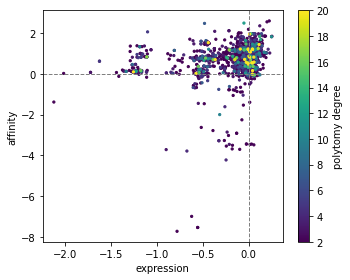

In [234]:
plt.figure(figsize=(5, 4))
plt.scatter(x=df[r"expression"], y=df[r"affinity"],
            c=df["polytomy degree"],
            s=5,
            vmax=20,
           )
plt.axvline(0, c="grey", ls="--", lw=1)
plt.axhline(0, c="grey", ls="--", lw=1)
plt.ylabel(r"affinity")
plt.xlabel(r"expression")
plt.colorbar(label="polytomy degree")

plt.tight_layout()
plt.show()

# sns.violinplot(data=df, y=r"affinity", x=f"LBR $\geq$ {thresh}")
# plt.axhline(0, c="grey", ls="--", lw=1)

# plt.tight_layout()
# plt.savefig("output/plots/affinity-fitness.LBR_Vs_bind.pdf")
# plt.show()

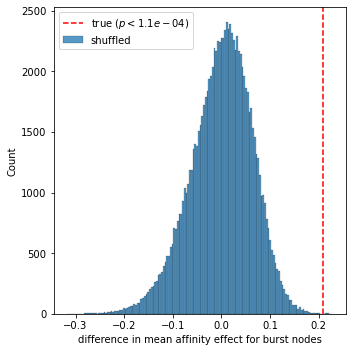

In [247]:
delta_mean = df.loc[df["burst"]==True, r"parent edge $\Delta$ affinity"].mean() - df.loc[df["burst"]==False, r"parent edge $\Delta$ affinity"].mean()
delta_mean_sim = []
n_sim = 100000
burst_idxs = df["burst"] == True
affinities = df[r"parent edge $\Delta$ affinity"].values
for _ in range(n_sim):
    shuffled_idxs = np.random.permutation(df.index)
    shuffled_affinities = affinities[shuffled_idxs]    
    delta_mean_sim.append(shuffled_affinities[burst_idxs].mean() - shuffled_affinities[~burst_idxs].mean())

p = sum(x >= delta_mean for x in delta_mean_sim) / n_sim

plt.figure(figsize=(5, 5))
sns.histplot(x=delta_mean_sim, label="shuffled")
plt.axvline(delta_mean, c="r", ls="--", label=f"true ($p={p:.1e}$)")
plt.legend()
plt.xlabel(f"difference in mean affinity effect for burst nodes")
plt.tight_layout()
plt.savefig("output/plots/affinity-fitness.pvalue.pdf")
plt.show()

## Permissive mutations below burst nodes?

In [145]:
rows = []
burst_thresh = 10
for gc, tree in trees.items():
    for node in tree.tree.traverse():
        if not node.is_root():
            delta_delta_bind = node.delta_bind - node.up.delta_bind
            delta_delta_expr = node.delta_expr - node.up.delta_expr
            parent_polytomy_degree = len(node.up.children) + node.up.abundance
            rows.append([gc, node.name, node.dist, node.abundance, parent_polytomy_degree, parent_polytomy_degree > burst_thresh, delta_delta_bind, delta_delta_expr])
df = pd.DataFrame(rows, columns=["GC", "name", "branch length", "abundance", "parent polytomy degree", "parent burst" r"$\Delta\Delta$ affinity", r"$\Delta\Delta$ expression"])

# no 10-week
df = df.loc[~df.GC.str.startswith("mouse7") & ~df.GC.str.startswith("mouse8")]

df

,GC,name,branch length,abundance,parent polytomy degree,parent burst,$\Delta\Delta$ affinity,$\Delta\Delta$ expression
0,mouse1_GC1,seq37,4.0,1,5,False,-0.06082,0.14827
1,mouse1_GC1,seq47,11.0,1,5,False,-3.45668,-1.05627
2,mouse1_GC1,seq56,1.0,1,5,False,-0.80796,-0.15104
3,mouse1_GC1,25,4.0,0,5,False,-7.71074,-0.77924
4,mouse1_GC1,2,1.0,0,5,False,0.33100,-0.00561
...,...,...,...,...,...,...,...,...
5520,mouse6_GC77,seq37,2.0,3,3,False,-0.10438,-0.04884
5521,mouse6_GC77,seq19,2.0,1,2,False,0.00000,0.00000
5522,mouse6_GC77,seq40,1.0,1,2,False,-0.03494,-0.14250
5523,mouse6_GC77,seq56,1.0,1,4,False,0.04243,-0.01071


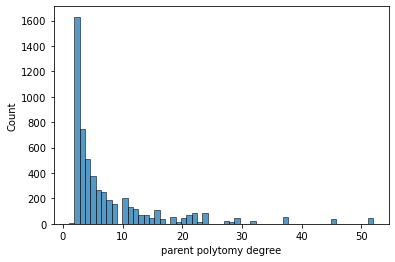

In [146]:
sns.histplot(df, x="parent polytomy degree")
plt.show()

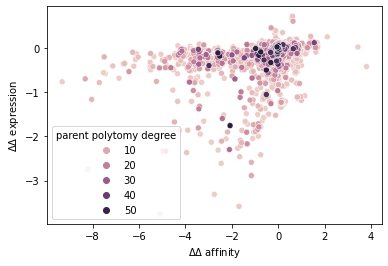

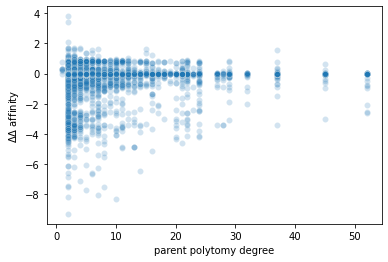

In [159]:
# plt.scatter(df["branch length"], df[r"$\Delta\Delta$ affinity"], c=df["parent polytomy degree"])
# plt.scatter(df["parent polytomy degree"], df[r"$\Delta\Delta$ affinity"])
sns.scatterplot(data=df.sort_values("parent polytomy degree"), x=r"$\Delta\Delta$ affinity", y=r"$\Delta\Delta$ expression", hue="parent polytomy degree")
plt.show()

sns.scatterplot(data=df, y=r"$\Delta\Delta$ affinity", x="parent polytomy degree", alpha=0.2)
# plt.xscale("log")
plt.show()

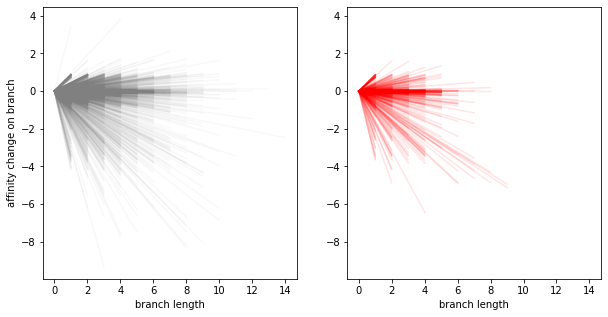

In [163]:
df_burst = df.loc[df["parent burst"]]
df_not_burst = df.loc[~df["parent burst"]]

plt.figure(figsize=(10, 5))
ax = plt.subplot(121)
plt.plot([[0] * len(df_not_burst), df_not_burst["branch length"]], [[0] * len(df_not_burst), df_not_burst[r"$\Delta\Delta$ affinity"]],
         color="grey", alpha=0.05)
plt.xlabel("branch length")
plt.ylabel("affinity change on branch")

plt.subplot(122, sharex=ax, sharey=ax)
plt.plot([[0] * len(df_burst), df_burst["branch length"]], [[0] * len(df_burst), df_burst[r"$\Delta\Delta$ affinity"]],
         color="red", alpha=0.1)
plt.xlabel("branch length")
plt.show()

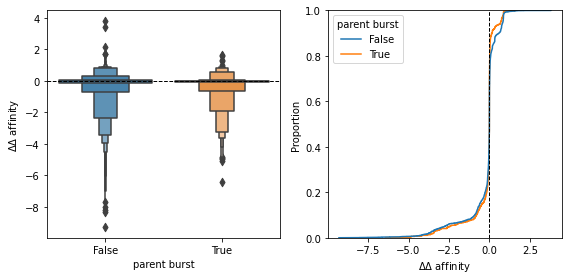

In [222]:
plt.figure(figsize=(8, 4))

plt.subplot(121)
sns.boxenplot(data=df, y=r"$\Delta\Delta$ affinity", x="parent burst")
plt.axhline(0, c="k", lw=1, ls="--")

plt.subplot(122)
sns.ecdfplot(data=df, x=r"$\Delta\Delta$ affinity", hue="parent burst")
plt.axvline(0, c="k", lw=1, ls="--")

plt.tight_layout()
plt.show()

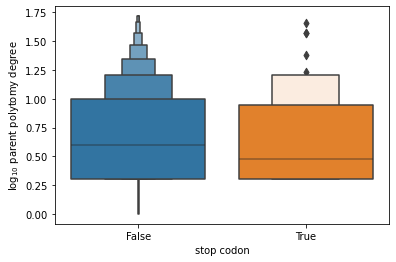

,parent is not a burst,parent is a burst
no stop codon,4307,1176
stop codon,34,8


In [195]:
df["stop codon"] = df[r"$\Delta\Delta$ affinity"].isna()
df[r"$\log_{10}$ parent polytomy degree"] = np.log10(df["parent polytomy degree"])

sns.boxenplot(data=df, x="stop codon", y=r"$\log_{10}$ parent polytomy degree")
plt.show()

contingency = pd.DataFrame([[sum(~df["stop codon"] & ~df["parent burst"]), sum(~df["stop codon"] & df["parent burst"])],
                   [sum(df["stop codon"] & ~df["parent burst"]), sum(df["stop codon"] & df["parent burst"])]],
                  index=["no stop codon", "stop codon"], columns=["parent is not a burst", "parent is a burst"])
contingency

In [189]:
1176 / (4307 + 1176), 8 / (34 + 8)

(0.21448112347255152, 0.19047619047619047)

In [196]:
34 / (34 + 4307), 8 / (8 + 1176)

(0.00783229670582815, 0.006756756756756757)